# Brain registration (alignment)

We will use **brainreg** package for image registration/alignment: https://github.com/brainglobe/brainreg <br/>
First, we need to install the package:  (should already be installed system-wide)

In [1]:
!pip install --user brainreg

Let's save some time by adding link to the atlas instead of downloading it:

In [42]:
!if [ ! -d ~/.brainglobe ]; then mkdir ~/.brainglobe; fi
!if [ ! -d ~/.brainglobe/allen_mouse_25um_v1.2 ]; then ln -s /bil/workshops/2022/data_submission/july/allen_mouse_25um_v1.2 ~/.brainglobe/allen_mouse_25um_v1.2; fi

We then import all required dependencies: <br/>
Please give it some time...

In [43]:
from glob import glob
import json
import os
import subprocess
from pathlib import Path

from bg_atlasapi.bg_atlas import BrainGlobeAtlas
import bg_space as bgs
import dask
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from scipy import ndimage
from skimage.filters import threshold_triangle
from skimage.measure import label, regionprops
from skimage.morphology import disk, opening
from skimage.transform import resize
from skimage import exposure
import tifffile

plt.rcParams['figure.figsize'] = [15, 15]

The results will be saved to your home directory:

In [44]:
home = Path.home()
print(home)

/bil/users/noisysky


We'll be registering a dataset to the Allen adult mouse brain atlas with 25 micron voxel spacing (isotropic) <br/>
https://mouse.brain-map.org/

In [45]:
atlas = BrainGlobeAtlas('allen_mouse_25um')

In [46]:
# helper function for plots

def stretch_contrast(img):
    img_dtype = img.dtype
    dtype_max = np.iinfo(img_dtype).max
    img = img.astype(np.float32)
    p2, p98 = np.percentile(img, (2, 98))
    img = exposure.rescale_intensity(img, in_range=(p2, p98))
    img = (img * dtype_max).astype(img_dtype)
    return img

## Step2: pre-processing

Let's load the downsampled 3D stack as numpy.ndarray:

In [47]:
downsampled_stack = tifffile.imread("/bil/workshops/2022/data_submission/july/fMOST_example_25um_isotropic_ARS.tif")

In [48]:
downsampled_stack.shape

(457, 412, 279)

Let's explore a 2D slice of our stack:

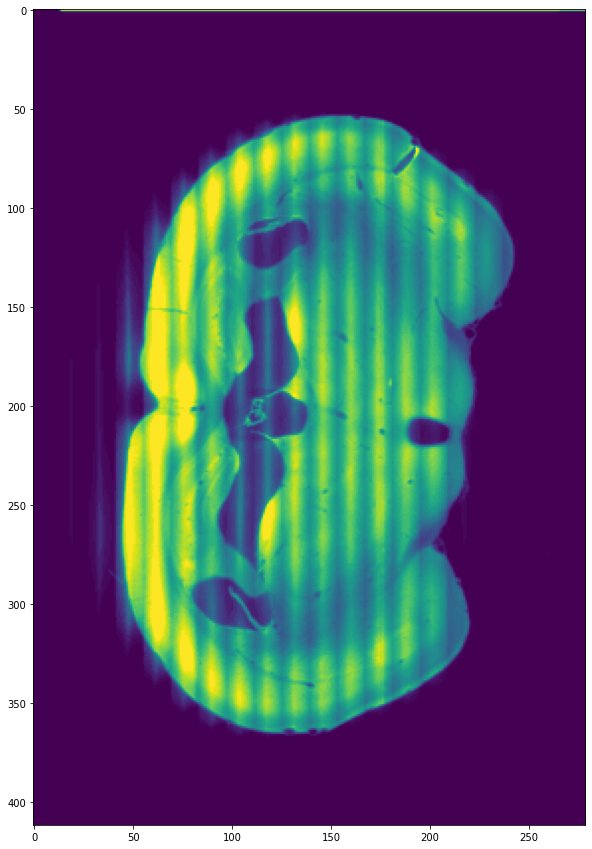

In [49]:
plt.imshow(stretch_contrast(downsampled_stack[220,:,:]))

To do pre-processing consistently, we need to work with all datasets in the same orientation:
the same as atlas orientation

In [50]:
downsampled_stack = bgs.map_stack_to("ars", atlas.orientation, downsampled_stack)

In [51]:
downsampled_stack.shape

(457, 279, 412)

Now our image dimensions are in the different order.

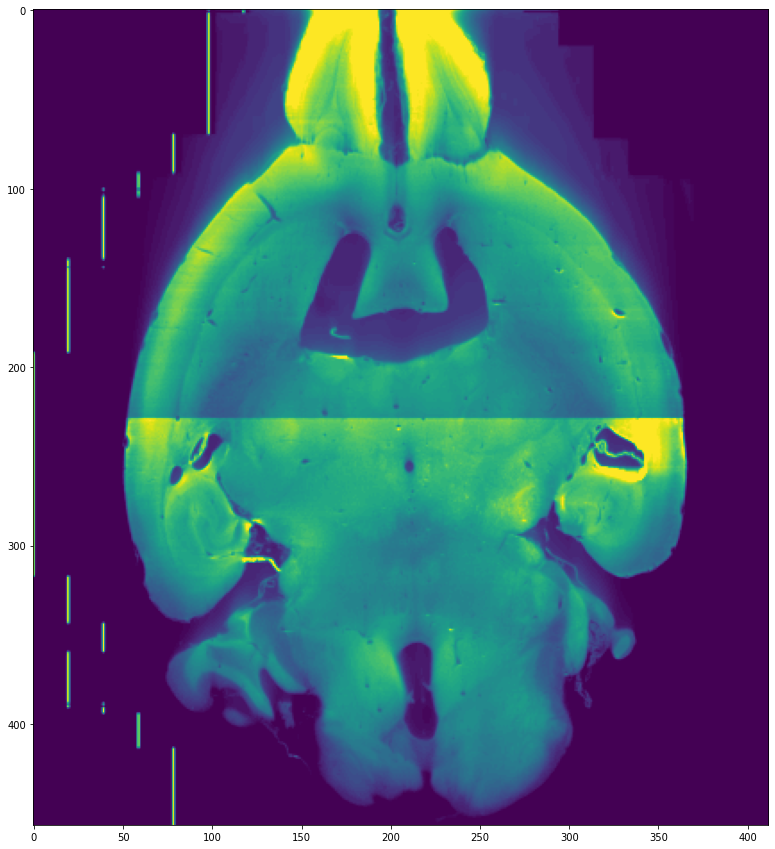

In [53]:
plt.imshow(stretch_contrast(downsampled_stack[:,150,:]))

#### Remove stripes

Our dataset has a striped artifact and an edge (background) artifact, which hinder registration. <br/>
Let's remove stripes first. <br/>
We'll do it in frequency domain using Fast Fourier Transform (FFT). <br/>
Let's define a few helper functions.

In [54]:
def ideal_notch_filter(fshift, points):
    d0 = 121.0  # cutoff frequency
    H, W = fshift.shape
    u, v = np.ogrid[:H, :W]
    for d in range(len(points)):
        u0, v0 = points[d]
        mask1 = (u - u0)**2 + (v - v0)**2 <= d0
        mask2 = (u + u0)**2 + (v + v0)**2 <= d0
        fshift[mask1] = 0
        fshift[mask2] = 0
    return fshift


def gaussian_notch_filter(fft_shift_img, points):
    d0 = 71  # cutoff frequency
    H, W = fft_shift_img.shape
    u, v = np.ogrid[:H, :W]
    for d in range(len(points)):
        u0, v0 = points[d]
        d1 = ((u - u0)**2 + (v - v0)**2)**0.5
        d2 = ((u + u0)**2 + (v + v0)**2)**0.5
        fft_shift_img[u,v] *= (1 - np.exp(-0.5 * (d1 * d2 / d0**2)))
    return fft_shift_img


def calculate_first_harmonic(image):
    """
    Calculate as argmax().
    
    stripes_period = int(np.floor(1./first_harmonic*len(sum_ax1)))
    """
    sum_ax1 = np.sum(image.astype(np.float32), axis=1)
    r_fft_transf = np.fft.rfft(sum_ax1)/sum_ax1.shape[0]
    first_harmonic = np.argmax(abs(r_fft_transf)[10:]) + 10
    return first_harmonic


def fft_2d_notch_filter(image, stripes_direction="h", filter="i"):
    """
    stripes_direction: "h" (horizontal stripes) or "v" (vertical stripes)
    filter: "g" (gaussian notch filter) or "i" (ideal notch filter)
    """
    image_dtype = image.dtype
    image = image.astype(np.float32)
    first_harmonic = calculate_first_harmonic(image)
    H, W = image.shape

    # do 2D fft
    img_fft = np.fft.fft2(image) / (W * H)
    # shift fft to get maximum at the center
    img_fft = np.fft.fftshift(img_fft)

    # filter shifted fft
    points = []
    image_center = (H // 2, W // 2)
    if stripes_direction == "h":
        # compute points on vertical axis of symmetry
        for point_ind in range(1, image_center[0] // first_harmonic):
            points.extend([
                [image_center[0] + point_ind * first_harmonic, image_center[1]],
                [image_center[0] - point_ind * first_harmonic, image_center[1]]
            ])
    elif stripes_direction == "v":
        # compute points on horizontal axis of symmetry
        for point_ind in range(1, image_center[1] // first_harmonic):
            points.extend([
                [image_center[0], image_center[1] + point_ind * first_harmonic],
                [image_center[0], image_center[1] - point_ind * first_harmonic]
            ])
    else:
        raise NotImplemented("Can only automatically remove vertical or horizontal stripes")
    points = np.asarray(points)
    
    if filter == "g":
        filtered_fft_shift = gaussian_notch_filter(img_fft, points)
    else:
        filtered_fft_shift = ideal_notch_filter(img_fft, points)

    # unshift
    img_fft = np.fft.ifftshift(filtered_fft_shift)
    # do inverse fft
    out_ifft = np.fft.ifft2(img_fft)
    image = (np.abs(out_ifft) * W * H).astype(image_dtype)
    return image

Let's pick a single 2D image layer and try to remove stripes in it.

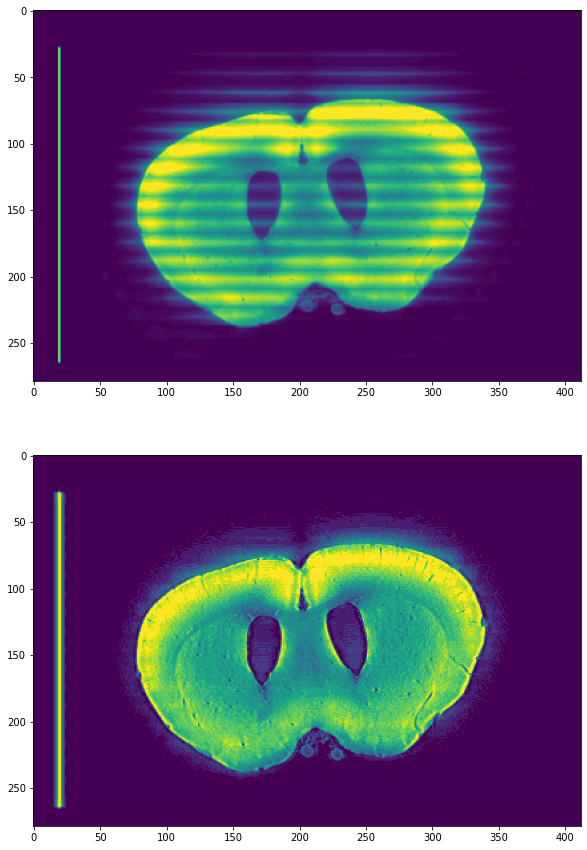

In [14]:
layer = downsampled_stack[150,:,:]
layer_cleaned = fft_2d_notch_filter(layer, filter="g")
fig, (ax1, ax2) = plt.subplots(2)
ax1.imshow(stretch_contrast(layer))
ax2.imshow(stretch_contrast(layer_cleaned))

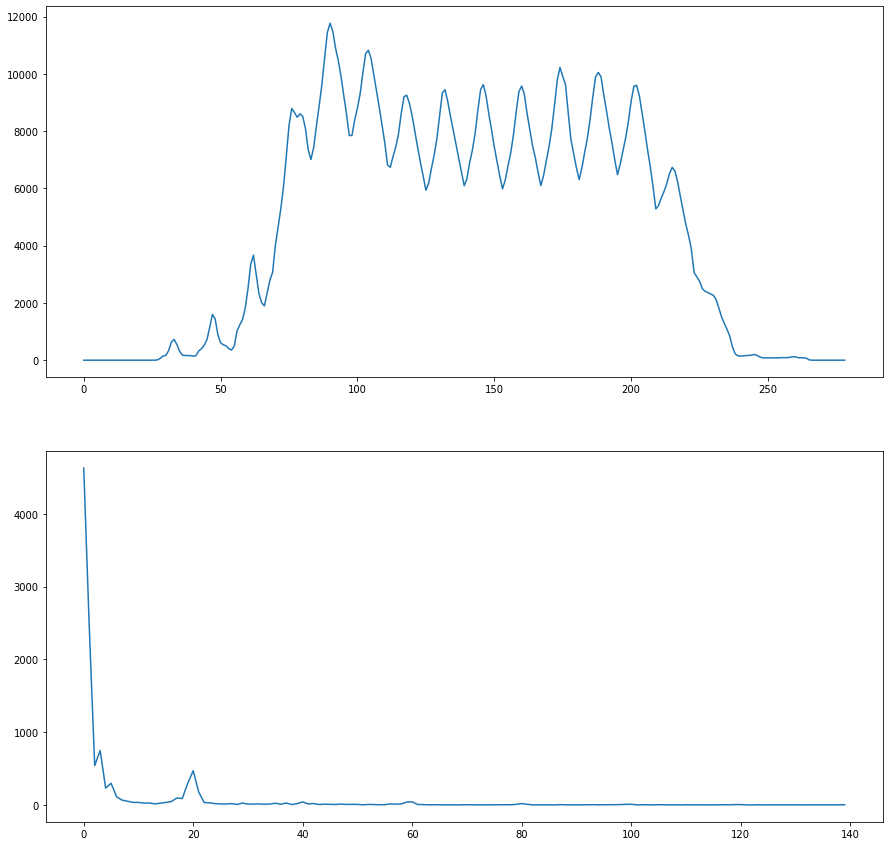

In [15]:
sum_ax1 = np.sum(layer.astype(np.float32), axis=1)
r_fft_transf = np.fft.rfft(sum_ax1)/sum_ax1.shape[0]
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(sum_ax1)
ax2.plot(abs(r_fft_transf))

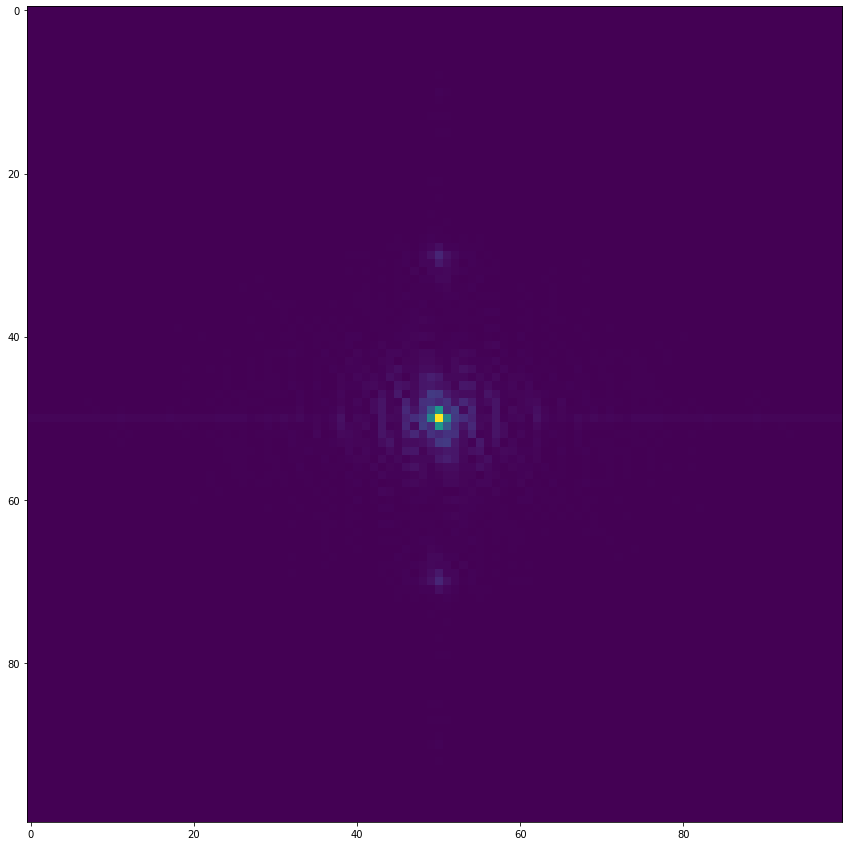

In [16]:
H, W = layer.shape
img_fft = np.fft.fft2(layer.astype(np.float32)) / (W * H)
img_fft = np.fft.fftshift(img_fft)
plt.imshow(abs(img_fft[(H//2 - 50) : (H//2 + 50), (W//2 - 50) : (W//2 + 50)]))

#### Remove background

Let's define a helper function that will threshold (binarize) the image to segment foreground (brain) and background.

In [55]:
def subtract_background_iterative(img):
    """
    Compute foreground/background mask by iteratively changing the threshold.

    :param img: image plane
    :return: mask (0s and 1s)
    """

    max_iterations = 100
    max_components = 1
    
    def compute_mask(img, thr):
        mask = (img > thr).astype(np.uint8)
        mask = (ndimage.binary_fill_holes(mask)).astype(np.uint8)
        kernel = disk(3)
        mask = (opening(mask, kernel)).astype(np.uint8)
        return mask

    img_pixels = img.shape[0] * img.shape[1]
    percent0 = 0
    img = img.astype(np.float32)
    try:
        threshold = threshold_triangle(img)
    except ValueError:  # attempt to get argmax of an empty sequence
        return np.zeros_like(img).astype(np.uint8)
    
    iteration = 0
    while percent0 < 20:
        # Increase threshold
        if iteration > max_iterations:
            return np.zeros_like(img)
        threshold = threshold + 0.15 * threshold
        mask = None
        mask = compute_mask(img, threshold)
        percent0 = (mask[mask == 0].shape[0]) / img_pixels * 100
        iteration += 1

    while percent0 > 95:
        # Decrease threshold
        if iteration > max_iterations:
            return np.zeros_like(img)
        threshold = threshold - 0.15 * threshold
        mask = None
        mask = compute_mask(img, threshold)
        percent0 = (mask[mask == 0].shape[0]) / img_pixels * 100
        iteration += 1

    label_image = label(mask)
    rp = regionprops(label_image)
    rp = sorted(rp, key=lambda x: x.area, reverse=True)
    final_mask = np.zeros_like(mask)
    for i in range(min([max_components, len(rp)])):
        for c in rp[i].coords:
            final_mask[c[0], c[1]] = 1
    return final_mask

Now let's get the binary foreground/background mask for our image layer.

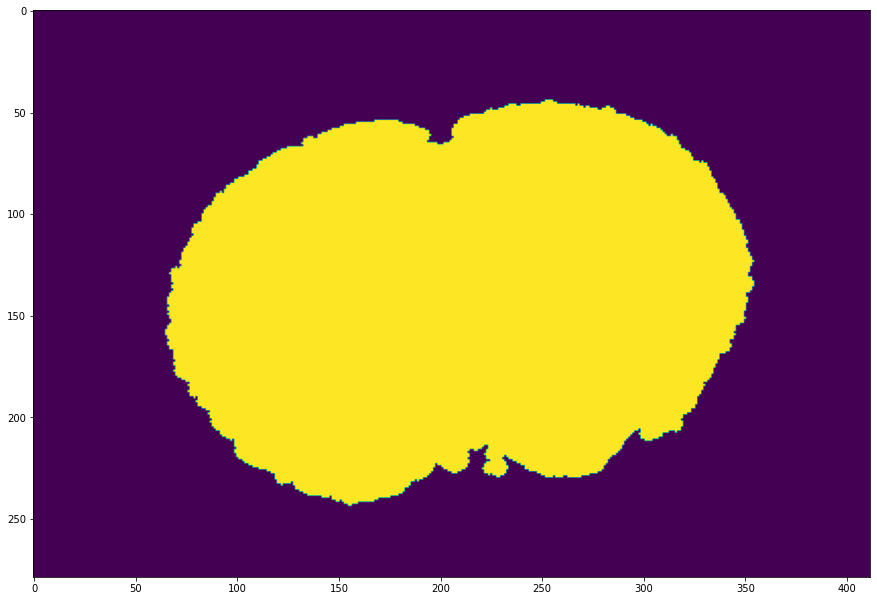

In [18]:
bg_mask = subtract_background_iterative(layer_cleaned)
plt.imshow(bg_mask)

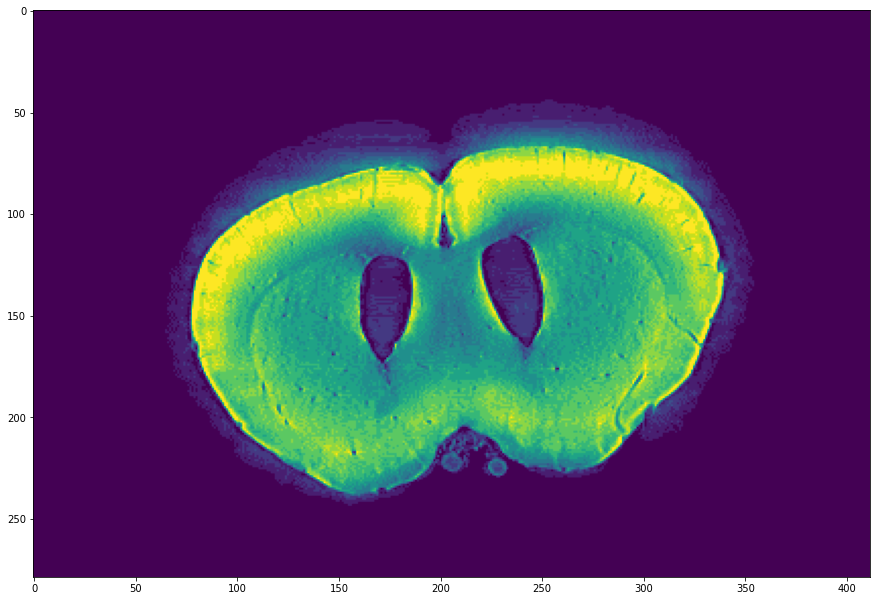

In [19]:
layer_cleaned[bg_mask == 0] = 0
plt.imshow(stretch_contrast(layer_cleaned))

Now let's apply pre-processing to the whole 3D image:

In [56]:
def pre_process_sequential(d_stack):
    img_preprocessed = np.empty_like(d_stack)
    for x in range(d_stack.shape[0]):
        if x % 100 == 0:
            print(f"{x} of {d_stack.shape[0]}")
        sl = d_stack[x,:,:]
        sl_fft = fft_2d_notch_filter(sl)
        m = subtract_background_iterative(sl_fft)
        sl_fft[m == 0] = 0
        img_preprocessed[x,:,:] = sl_fft
    return img_preprocessed


def pre_process_parallel(d_stack):
    def remove_stripes(img):
        return fft_2d_notch_filter(img)

    def get_mask(img):
        return subtract_background_iterative(img)

    def remove_bg(img, mask):
        img[mask == 0] = 0
        return img
    
    def save_img(ind, img):
        img_preprocessed[ind, :, :] = img
        return True
    
    img_planes = list(d_stack)
    clean_img_planes = [dask.delayed(remove_stripes)(i) for i in img_planes]
    masks = [dask.delayed(get_mask)(i) for i in clean_img_planes]
    img_planes_no_bg = [dask.delayed(remove_bg)(i, m) for i, m in zip(clean_img_planes, masks)]
    saved = [dask.delayed(save_img)(x, i) for x, i in enumerate(img_planes_no_bg)]
    saved = dask.compute(saved)


In [57]:
img_preprocessed = np.empty(downsampled_stack.shape, downsampled_stack.dtype)
pre_process_parallel(downsampled_stack)

In [58]:
tifffile.imwrite(str(home / "tmp" / "preprocessed_fMOST_example_25um_isotropic_reoriented.tif"), img_preprocessed)

## Step 3: register image

Now we can register the image using brainreg. <br/>
To see all brainreg command line tool options, run:

In [23]:
!brainreg --help
# !brainreg /bil/users/noisysky/tmp/preprocessed_fMOST_example_10um_isotropic_reoriented.tif /bil/users/noisysky/registration_fMOST_example -v 10 10 10 --orientation sla --atlas allen_mouse_25um --debug

usage: brainreg [-h] [-d DOWNSAMPLE_IMAGES [DOWNSAMPLE_IMAGES ...]]
                [--version] [--atlas ATLAS] [--backend BACKEND]
                [--affine-n-steps AFFINE_N_STEPS]
                [--affine-use-n-steps AFFINE_USE_N_STEPS]
                [--freeform-n-steps FREEFORM_N_STEPS]
                [--freeform-use-n-steps FREEFORM_USE_N_STEPS]
                [--bending-energy-weight BENDING_ENERGY_WEIGHT]
                [--grid-spacing GRID_SPACING]
                [--smoothing-sigma-reference SMOOTHING_SIGMA_REFERENCE]
                [--smoothing-sigma-floating SMOOTHING_SIGMA_FLOATING]
                [--histogram-n-bins-floating HISTOGRAM_N_BINS_FLOATING]
                [--histogram-n-bins-reference HISTOGRAM_N_BINS_REFERENCE] -v
                VOXEL_SIZES [VOXEL_SIZES ...] --orientation ORIENTATION
                [--n-free-cpus N_FREE_CPUS] [--debug]
                [--save-original-orientation] [--sort-input-file]
                image_paths brainreg_directory

opt

But we'll use python's subprocess module, to reuse the variables that we have. <br/>
This is also the way to include brainreg into a larger pipeline.

In [59]:
# registration wrapper function
def launch_registration(input_file, output_folder, atlas, resolution, orientation):
    cmd = [
        'brainreg', input_file, output_folder,
        '-v', str(resolution[0]), str(resolution[1]), str(resolution[2]),
        '--orientation', orientation,
        '--atlas', atlas,
        '--save-original-orientation'
    ]

    ret = subprocess.run(cmd)

Actual start of registration. It will take around 20 minutes. There will be a lot of output indicating what stage of registration is performed.

In [60]:
resolution = atlas.resolution
orientation = atlas.orientation
atlas_name = atlas.atlas_name
input_file = "/bil/workshops/2022/data_submission/july/preprocessed_fMOST_example_25um_isotropic_reoriented.tif"
output_folder = str(home / "registration_fMOST_example_25um")

launch_registration(input_file, output_folder, atlas_name, resolution, orientation)

INFO:root:Starting logging
INFO:root:Not logging multiple processes
INFO:root:Starting registration


2022-07-28 14:21:44 PM INFO     2022-07-28 14:21:44 PM - INFO -  fancylog.py:307
                                MainProcess fancylog.py:307 -                   
                                Starting logging                                
                       INFO     2022-07-28 14:21:44 PM - INFO -  fancylog.py:308
                                MainProcess fancylog.py:308 -                   
                                Not logging multiple processes                  
                       INFO     2022-07-28 14:21:44 PM - INFO -       cli.py:205
                                MainProcess cli.py:205 - Starting               
                                registration                                    


DEBUG:root:Determining the maximum number of CPU cores to use
DEBUG:root:Number of CPU cores available is: 4
DEBUG:root:Setting number of processes to: 4
INFO:root:Loading raw image data
DEBUG:root:Data type is: tif stack
DEBUG:root:Loading: /bil/workshops/2022/data_submission/july/preprocessed_fMOST_example_25um_isotropic_reoriented.tif


2022-07-28 14:21:46 PM INFO     2022-07-28 14:21:46 PM - INFO -       main.py:49
                                MainProcess main.py:49 - Loading raw            
                                image data                                      


filtering:   0%|          | 0/456 [00:00<?, ?plane/s]/bil/packages/anaconda3/4.11.0/lib/python3.9/site-packages/skimage/_shared/utils.py:274: FutureWarning: `selem` is a deprecated argument name for `opening`. It will be removed in version 1.0. Please use `footprint` instead.
  warnings.warn(self.warning_msg.format(
filtering: 100%|██████████| 412/412 [00:06<00:00, 65.85plane/s]
INFO:root:Registering
INFO:root:Starting affine registration


2022-07-28 14:22:10 PM INFO     2022-07-28 14:22:10 PM - INFO -        run.py:61
                                MainProcess run.py:61 - Registering             
                       INFO     2022-07-28 14:22:10 PM - INFO -        run.py:81
                                MainProcess run.py:81 - Starting                
                                affine registration                             


INFO:root:Starting freeform registration


2022-07-28 14:24:40 PM INFO     2022-07-28 14:24:40 PM - INFO -        run.py:84
                                MainProcess run.py:84 - Starting                
                                freeform registration                           


INFO:root:Starting segmentation


2022-07-28 14:24:57 PM INFO     2022-07-28 14:24:57 PM - INFO -        run.py:87
                                MainProcess run.py:87 - Starting                
                                segmentation                                    


INFO:root:Segmenting hemispheres


2022-07-28 14:24:59 PM INFO     2022-07-28 14:24:59 PM - INFO -        run.py:90
                                MainProcess run.py:90 - Segmenting              
                                hemispheres                                     


INFO:root:Generating inverse (sample to atlas) transforms
DEBUG:root:Generating inverse affine transform
DEBUG:root:Registering sample to atlas


2022-07-28 14:25:01 PM INFO     2022-07-28 14:25:01 PM - INFO -        run.py:93
                                MainProcess run.py:93 - Generating              
                                inverse (sample to atlas) transforms            


INFO:root:Transforming image to standard space


2022-07-28 14:25:23 PM INFO     2022-07-28 14:25:23 PM - INFO -        run.py:96
                                MainProcess run.py:96 - Transforming            
                                image to standard space                         


INFO:root:Generating deformation field
INFO:root:Generating deformation field


2022-07-28 14:25:26 PM INFO     2022-07-28 14:25:26 PM - INFO -       run.py:102
                                MainProcess run.py:102 - Generating             
                                deformation field                               
                       INFO     2022-07-28 14:25:26 PM -     registration.py:287
                                INFO - MainProcess                              
                                registration.py:287 -                           
                                Generating deformation field                    


INFO:root:Exporting images as tiff
DEBUG:root:Data type is: NifTI
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2022-07-28 14:25:28 PM INFO     2022-07-28 14:25:28 PM - INFO -       run.py:105
                                MainProcess run.py:105 - Exporting              
                                images as tiff                                  
                       INFO     2022-07-28 14:25:28 PM -   batteryrunners.py:274
                                INFO - MainProcess                              
                                batteryrunners.py:274 -                         
                                pixdim[0] (qfac) should be                      
                                1 (default) or -1; setting                      
                                qfac to 1                                       


DEBUG:root:Data type is: NifTI
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2022-07-28 14:25:29 PM INFO     2022-07-28 14:25:29 PM -   batteryrunners.py:274
                                INFO - MainProcess                              
                                batteryrunners.py:274 -                         
                                pixdim[0] (qfac) should be                      
                                1 (default) or -1; setting                      
                                qfac to 1                                       


DEBUG:root:Data type is: NifTI
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2022-07-28 14:25:30 PM INFO     2022-07-28 14:25:30 PM -   batteryrunners.py:274
                                INFO - MainProcess                              
                                batteryrunners.py:274 -                         
                                pixdim[0] (qfac) should be                      
                                1 (default) or -1; setting                      
                                qfac to 1                                       


DEBUG:root:Data type is: NifTI
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2022-07-28 14:25:31 PM INFO     2022-07-28 14:25:31 PM -   batteryrunners.py:274
                                INFO - MainProcess                              
                                batteryrunners.py:274 -                         
                                pixdim[0] (qfac) should be                      
                                1 (default) or -1; setting                      
                                qfac to 1                                       


DEBUG:root:Data type is: NifTI
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2022-07-28 14:25:32 PM INFO     2022-07-28 14:25:32 PM -   batteryrunners.py:274
                                INFO - MainProcess                              
                                batteryrunners.py:274 -                         
                                pixdim[0] (qfac) should be                      
                                1 (default) or -1; setting                      
                                qfac to 1                                       


INFO:root:Deleting intermediate niftyreg files


2022-07-28 14:25:34 PM INFO     2022-07-28 14:25:34 PM - INFO -       run.py:213
                                MainProcess run.py:213 - Deleting               
                                intermediate niftyreg files                     


INFO:root:Calculating volumes of each brain area
DEBUG:root:Data type is: tif stack
DEBUG:root:Loading: /bil/users/noisysky/registration_fMOST_example_25um/registered_atlas.tiff
DEBUG:root:Data type is: tif stack
DEBUG:root:Loading: /bil/users/noisysky/registration_fMOST_example_25um/registered_hemispheres.tiff


2022-07-28 14:25:35 PM INFO     2022-07-28 14:25:35 PM - INFO -       main.py:83
                                MainProcess main.py:83 - Calculating            
                                volumes of each brain area                      


INFO:root:Generating boundary image
DEBUG:root:Data type is: tif stack
DEBUG:root:Loading: /bil/users/noisysky/registration_fMOST_example_25um/registered_atlas.tiff


2022-07-28 14:25:38 PM INFO     2022-07-28 14:25:38 PM - INFO -       main.py:94
                                MainProcess main.py:94 - Generating             
                                boundary image                                  


DEBUG:root:Saving segmentation boundary image
INFO:root:brainreg completed. Results can be found here: /bil/users/noisysky/registration_fMOST_example_25um
INFO:root:Finished. Total time taken: 0:03:55.664821


2022-07-28 14:25:40 PM INFO     2022-07-28 14:25:40 PM - INFO -      main.py:100
                                MainProcess main.py:100 - brainreg              
                                completed. Results can be found                 
                                here:                                           
                                /bil/users/noisysky/registration_fMO            
                                ST_example_25um                                 
                       INFO     2022-07-28 14:25:40 PM - INFO -       cli.py:222
                                MainProcess cli.py:222 - Finished.              
                                Total time taken: 0:03:55.664821                


After it's done, we can explore the results. <br/>
We can explore the raw brain image warped into atlas space.

In [61]:
transformed_img = tifffile.imread(str(home / "registration_fMOST_example_25um" / "downsampled_standard.tiff"))

It is the same shape as atlas reference template:

In [62]:
transformed_img.shape == atlas.shape

True

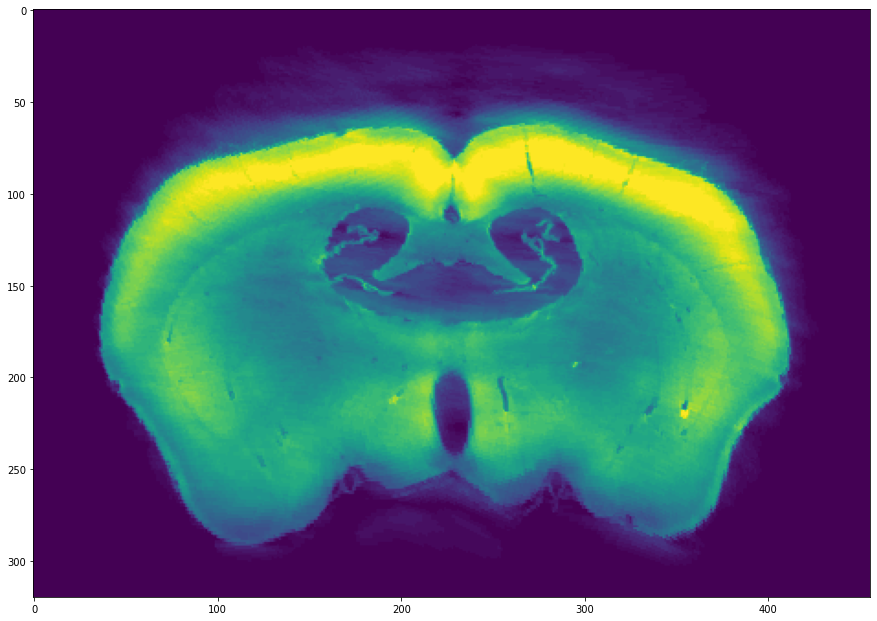

In [28]:
plt.imshow(stretch_contrast(transformed_img[250,:,:]))

Registration runs both ways: atlas to sample and sample to atlas. <br/>
Let's see atlas segmentation warped into the original image:

In [29]:
downsampled_img = tifffile.imread(str(home / "registration_fMOST_example_25um" / "downsampled.tiff"))
boundary_img = tifffile.imread(str(home / "registration_fMOST_example_25um" / "boundaries.tiff"))
downsampled_img.shape

(457, 279, 412)

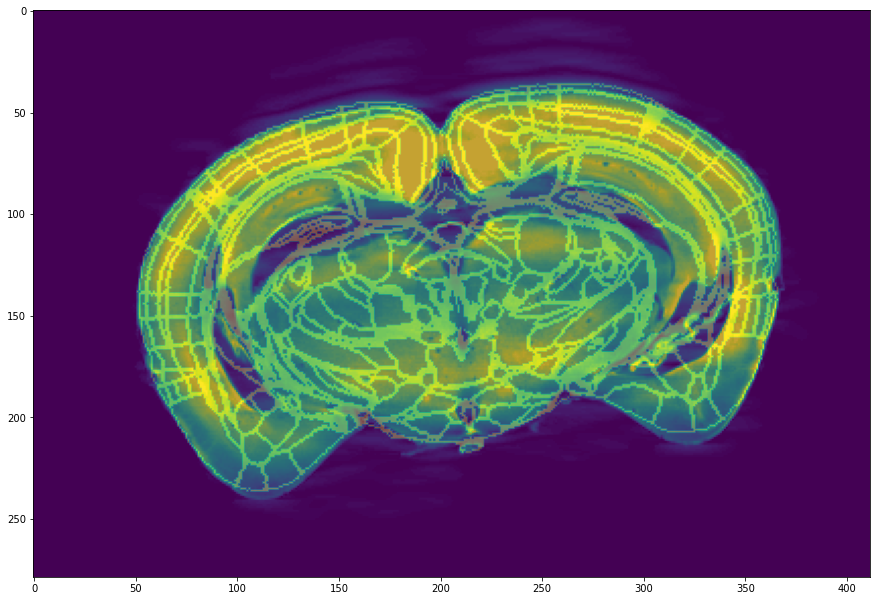

In [30]:
plt.imshow(stretch_contrast(downsampled_img[250,:,:]))
plt.imshow(boundary_img[250,:,:], alpha=0.3)

## Step 4: Using deformation fields

Deformation field is the most useful registration product that allows us to transform objects (points, meshes, tracks etc) from one space to another. <br/>
Let's run through an example of transforming points from raw image space to the atlas space.

In [63]:
img = tifffile.imread("/bil/data/df/75/df75626840c76c15/mouseID_373187-191817/CH2/191817_06000_CH2.tif")

Let's define a few points in different brain regions (same z layer is taken for the ease of plotting)
Let's see what atlas structures these points correspond to.

In [64]:
point1_xy = (20000, 3500)
point2_xy = (15000, 10000)
point_z = 6000

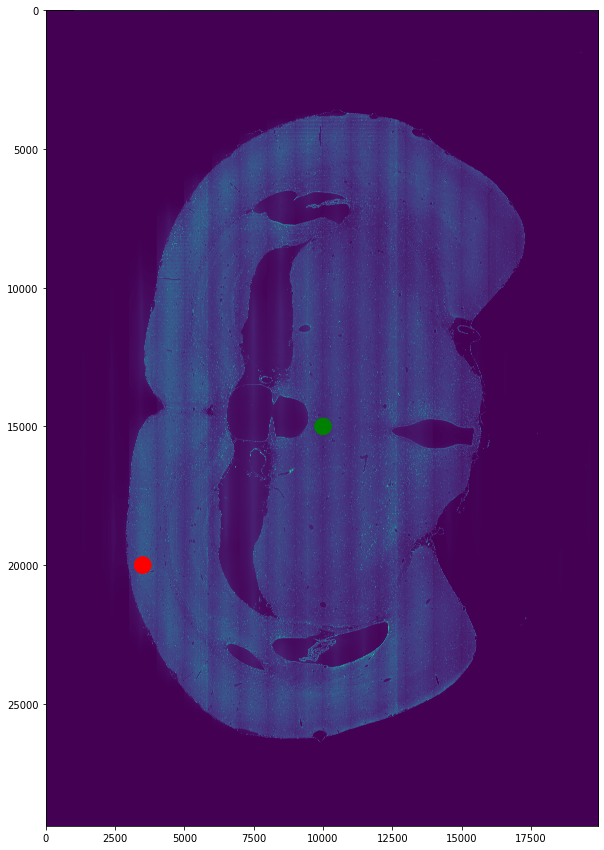

In [33]:
from matplotlib.patches import Circle
circ1 = Circle((point1_xy[1], point1_xy[0]), 300, color="red")
circ2 = Circle((point2_xy[1], point2_xy[0]), 300, color="green")
fig, ax = plt.subplots(1)
ax.set_aspect('equal')
ax.imshow(img)
ax.add_patch(circ1)
ax.add_patch(circ2)

Let's define raw image space and intermediate downsampled image space (with the same voxel spacing as atlas voxel spacing):

In [65]:
raw_space = bgs.AnatomicalSpace(
    'ars',
    shape=(11428, 19906, 29401),
    resolution=(1, 0.35, 0.35),
)

downsampled_space = bgs.AnatomicalSpace(
    atlas.metadata["orientation"],
    shape=downsampled_img.shape,
    resolution=atlas.resolution,
)

Let's first transform points from raw to downsampled space, and then from downsampled to atlas space:

In [66]:
#  taken from cellfinder: https://github.com/brainglobe/cellfinder

def transform_points_to_downsampled_space(
    points: np.ndarray,
    target_space: bgs.AnatomicalSpace,
    source_space: bgs.AnatomicalSpace,
) -> np.ndarray:
    points = source_space.map_points_to(target_space, points)
    return points


def transform_points_downsampled_to_atlas_space(
    downsampled_points, atlas, deformation_field_paths
):
    field_scales = [int(1000 / resolution) for resolution in atlas.resolution]
    points = [[], [], []]
    for axis, deformation_field_path in enumerate(deformation_field_paths):
        deformation_field = tifffile.imread(deformation_field_path)
        for point in downsampled_points:
            try:
                point = [int(round(p)) for p in point]
                points[axis].append(
                    int(
                        round(
                            field_scales[axis]
                            * deformation_field[point[0], point[1], point[2]]
                        )
                    )
                )
            except IndexError:
                log.warning(
                    f'IndexError when transforming point ({point[0]},{point[1]},{point[2]}) from downsampled to atlas space.'
                )
    transformed_points = np.array(points).T

    return transformed_points

In [67]:
points = np.array([[point_z, *point1_xy], [point_z, *point2_xy]])
points.shape

(2, 3)

In [68]:
downsampled_points = transform_points_to_downsampled_space(points, downsampled_space, raw_space)

In [69]:
downsampled_points

array([[240.,  49., 280.],
       [240., 140., 210.]])

In [39]:
deform_fields = [
    str(home / "registration_fMOST_example_25um" / "deformation_field_0.tiff"),
    str(home / "registration_fMOST_example_25um" / "deformation_field_1.tiff"),
    str(home / "registration_fMOST_example_25um" / "deformation_field_2.tiff")
]
transformed_points = transform_points_downsampled_to_atlas_space(downsampled_points, atlas, deform_fields)

In [40]:
transformed_points

array([[328,  37, 333],
       [297, 153, 230]])

Now that we have coordinates of our points in the atlas space, we can see what structures they are in.

In [70]:
structures = []

for ind in range(transformed_points.shape[0]):
    if np.any(transformed_points[ind] < 0):
        structures.append("")
        continue
    try:
        atlas_value = atlas.annotation[
            transformed_points[ind, 0],
            transformed_points[ind, 1],
            transformed_points[ind, 2]
        ]
        df_row = atlas.lookup_df.index[atlas.lookup_df['id'] == atlas_value]
        row_values = atlas.lookup_df.iloc[df_row]
        structure_name = row_values['name'].values[0]
        structure_code = row_values['acronym'].values[0]
        print(f"Point {ind}. Structure name: {structure_name}, structure code {structure_code}")
        structures.append(structure_name)
    except Exception as e:
        print(e)
        structures.append("")

Point 0. Structure name: Primary visual area, layer 2/3, structure code VISp2/3
Point 1. Structure name: Paraventricular nucleus of the thalamus, structure code PVT


**If you want to save deformation fields from atlas to sample:
use this fork of brainreg:
https://github.com/noisysky/brainreg/tree/fmost-both-ways**